# Basics of atomman

This Jupyter Notebook outlines the basics of using atomman to set up, run and analyze a LAMMPS simulation from a Python environment.

[Click here for more complete atomman documentation](https://www.ctcms.nist.gov/potentials/atomman/)

## 1. Install

### 1.1. colab

If you are in a colab environment, the cell below will automatically install LAMMPS, atomman and other packages used here.

### 1.2. Local

The atomman package can be installed with pip or conda-forge.  The example used here also uses the optional py3Dmol package for the 3D views of the configurations.

```bash
pip install atomman py3Dml
```
or
```bash
conda install atomman py3Dml -c conda-forge
```

In [1]:
# Standard Python packages
import os
from pathlib import Path

# Test if this is a colab environment
iscolab = 'COLAB_RELEASE_TAG' in os.environ

# Install LAMMPS and atomman in colab if needed
if iscolab and not Path('lmp').exists():
    
    print('Installing LAMMPS - please wait...')
    !wget https://github.com/lmhale99/atomman-demo/raw/main/lmp.gz
    !gunzip lmp.gz
    !chmod 755 lmp
    
    print('Installing atomman')
    !pip install atomman py3Dmol

    print('!!!!! RESTART KERNEL/RUNTIME BEFORE CONTINUING!!!!!')
    
# Import installed packages
else:
    import atomman as am
    import atomman.unitconvert as uc
    print(f'atomman version {am.__version__} loaded')
    import matplotlib.pyplot as plt

atomman version 1.4.10 loaded


## 2. Load an interatomic potential

LAMMPS-compatible interatomic potentials can be automatically loaded from the Interatomic Potentials Repository using atomman.load_lammps_potential.

Here's a partial list of the query parameters for load_lammps_potential  
- __name__ or __id__ (*str or list*) The implementation ID(s) to parse by. These are the unique IDs listed on the repository website for a particular implementation that contain --LAMMPS--.
- __potid__ (*str or list*) The potential ID(s) to parse by. These are the unique IDs listed on the repository website at the top of each listing
- __pair_style__ (*str or list*) LAMMPS pair_style(s) to parse by.
- __symbols__ (*str or list*) Model symbol(s) to parse by. Typically correspond to elements for atomic potential models.

Also, setting getfiles=True will automatically copy/download the potential's parameter files from the database.

In [2]:
potential = am.load_lammps_potential(symbols='Al', pair_style='eam/alloy', getfiles=True)

Multiple matching records retrieved from local
1 1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1 Ni-Al-H
2 1996--Farkas-D--Nb-Ti-Al--LAMMPS--ipr1 Nb-Ti-Al
3 1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1 Al-Mg
4 1998--Liu-X-Y--Al-Mg--LAMMPS--ipr1 Al-Mg
5 1999--Liu-X-Y--Al-Cu--LAMMPS--ipr1 Al-Cu
6 1999--Mishin-Y--Al--LAMMPS--ipr1 Al
7 2000--Landa-A--Al-Pb--LAMMPS--ipr1 Al-Pb
8 2002--Mishin-Y--Ni-Al--LAMMPS--ipr1 Ni-Al
9 2003--Zope-R-R--Al--LAMMPS--ipr1 Al
10 2003--Zope-R-R--Ti-Al--LAMMPS--ipr1 Ti-Al
11 2004--Liu-X-Y--Al--LAMMPS--ipr1 Al
12 2004--Mishin-Y--Ni-Al--LAMMPS--ipr1 Ni-Al
13 2004--Mishin-Y--Ni-Al--LAMMPS--ipr2 Ni-Al
14 2004--Zhou-X-W--Al--LAMMPS--ipr2 Al
15 2009--Purja-Pun-G-P--Ni-Al--LAMMPS--ipr1 Ni-Al
16 2009--Zhakhovskii-V-V--Al--LAMMPS--ipr2 Al
17 2010--Winey-J-M--Al--LAMMPS--ipr1 Al
18 2012--Schopf-D--Al-Mn-Pd--LAMMPS--ipr1 Al-Mn-Pd
19 2015--Purja-Pun-G-P--Al-Co--LAMMPS--ipr2 Al-Co
20 2015--Purja-Pun-G-P--Ni-Al-Co--LAMMPS--ipr2 Ni-Al-Co
21 2020--Farkas-D--Fe-Ni-Cr-Co-Al--LAMMPS--ipr1 Fe-Ni-Cr

Please select one: 9


In [3]:
# pair_info gives an example of the LAMMPS commands to use and source comments
print(potential.pair_info())

print "Potential 2003--Zope-R-R--Al--LAMMPS--ipr1 listed in the NIST Interatomic Potentials Repository:"
print "https://www.ctcms.nist.gov/potentials/entry/2003--Zope-R-R-Mishin-Y--Al/2003--Zope-R-R--Al--LAMMPS--ipr1.html"
print "Publication(s) related to the potential:"
print "https://doi.org/10.1103/physrevb.68.024102"
print "Parameter file(s) can be downloaded at:"
print "https://www.ctcms.nist.gov/potentials/Download/2003--Zope-R-R-Mishin-Y--Al/2/Al03.eam.alloy"
print "https://www.ctcms.nist.gov/potentials/Download/2003--Zope-R-R-Mishin-Y--Al/2/Al03_releaseNotes_1.pdf"
pair_style eam/alloy
pair_coeff * * 2003--Zope-R-R--Al--LAMMPS--ipr1\Al03.eam.alloy Al
mass 1 26.982




In [4]:
# Check pair_info with comments turned off
print(potential.pair_info(comments=False))

pair_style eam/alloy
pair_coeff * * 2003--Zope-R-R--Al--LAMMPS--ipr1\Al03.eam.alloy Al
mass 1 26.982




## 3. Load or build an atomic configuration

Atomic configurations in atomman are represented as System objects. Each system is composed of 
- __box__ an atomman.Box object that represents the system's cell box and origin. 
- __atoms__ an atomman.Atoms object that contains per-atom values. Only atype and pos are required, but any property can be freely set.
- __pbc__ a tuple of three bools indicating which of the box dimensions are periodic.

### 3.1. Load a configuration

atomman.load() can be used to load an existing atomic configuration from a variety of sources.  The supported styles can be divided into local files, remote database files, and alternate Python representations:

- __Local file styles__
   - 'atom_data' LAMMPS data
    - 'atom_dump' LAMMPS dump
    - 'poscar'
    - 'cif'
    - 'system_model' JSON schema used by atomman
- __Remote database file styles__
    - 'prototype' crystal prototypes
    - 'crystal' crystals relaxed using a specific potential
- __Alternate Python representations__
    - 'ase_Atoms'
    - 'phonopy_Atoms'
    - 'pymatgen_Structure'
    - 'spglib_cell'


In [5]:
# Load a relaxed crystal structure from potentials.nist.gov specific to the selected potential
ucell = am.load('crystal', potential=potential)

print(ucell)
am.plot.py3Dmol.view_3d(ucell, height=400, width=400)

Multiple matching record retrieved from local
#  family               symbols  alat    Ecoh    method  standing
 1 A1--Cu--fcc          Al        4.0500 -3.3539 dynamic good
 2 A3'--alpha-La--doubl Al        2.8465 -3.3406 dynamic good
 3 A15--beta-W          Al        5.0772 -3.3374 dynamic good
 4 A3--Mg--hcp          Al        2.8357 -3.3324 dynamic good
 5 oqmd-1214770         Al        9.9436 -3.3251 dynamic good
 6 oqmd-1214859         Al        6.9849 -3.3169 dynamic good
 7 mp-1244953           Al       11.5978 -3.2843 dynamic good
 8 mp-1245152           Al       11.6604 -3.2781 dynamic good
 9 mp-1245129           Al       11.6485 -3.2776 dynamic good
10 mp-1245307           Al       11.6170 -3.2750 dynamic good
11 mp-1245067           Al       11.8751 -3.2736 dynamic good


Please select one: 1


avect =  [ 4.050,  0.000,  0.000]
bvect =  [ 0.000,  4.050,  0.000]
cvect =  [ 0.000,  0.000,  4.050]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 1
symbols = ('Al',)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   0.000 |   2.025 |   2.025
      2 |       1 |   2.025 |   0.000 |   2.025
      3 |       1 |   2.025 |   2.025 |   0.000


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

__NOTE__ the atomman.plot.py3Dmol.view_3d() method is still preliminary and may change.

### 3.2. Build a system manually

Alternatively, you can build a System manually from Box and Atoms objects

In [6]:
# Manually create a bcc unit cell for Fe
box = am.Box.cubic(a = uc.set_in_units(2.86, 'angstrom'))

atoms = am.Atoms(pos = [[0.0, 0.0, 0.0], [0.5, 0.5, 0.5]])

bcc_ucell = am.System(box=box, atoms=atoms, scale=True)

print(bcc_ucell)
am.plot.py3Dmol.view_3d(bcc_ucell, height=400, width=400)

avect =  [ 2.860,  0.000,  0.000]
bvect =  [ 0.000,  2.860,  0.000]
cvect =  [ 0.000,  0.000,  2.860]
origin = [ 0.000,  0.000,  0.000]
natoms = 2
natypes = 1
symbols = (None,)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   1.430 |   1.430 |   1.430


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## 4. Manipulate the system

### 4.1. Basic manipulations

- __rotate__ the system using Miller(-Bravais) integer vectors relative to the current box vectors. Creates a new system such that atoms remain coherent across periodic boundaries.
- __supersize__ the system by multiplying along the box directions in postive and/or negative directions. 

In [7]:
# Rotate such that the [111] direction is along the x-axis
uvws = [
    [ 1, 1, 1],
    [ 1,-2, 1],
    [ 1, 0,-1]
]
rcell = ucell.rotate(uvws)

# Multiply system along all three box directions, with origin positioned in the center of y, z lengths 
system = rcell.supersize((-4,4), (-3, 3), (-5, 5))

print(system.box)
print(system.natoms)
am.plot.py3Dmol.view_3d(system, height=400, width=400)

avect =  [56.118,  0.000,  0.000]
bvect =  [ 0.000, 59.523,  0.000]
cvect =  [ 0.000,  0.000, 57.276]
origin = [-28.059, -29.761, -28.638]
11520


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### 4.2. Region selection with atomman.region Shape objects

- Cylinder, Sphere, Box for 3D shapes
- Plane for slices
- PlaneSet to define volumes using multiple planes

In [8]:
sphere = am.region.Sphere(center = [0., 0., 0.], radius = 25)

System.atoms_ix returns a new system based on numpy-style indexing of atoms

In [9]:
sphere_system = system.atoms_ix[sphere.inside(system.atoms.pos)]
print(sphere_system.natoms)
am.plot.py3Dmol.view_3d(sphere_system)

3997


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### 4.3. Crystal defect configuration generators

The atomman.defect submodule contains many tools associated with generating standard configuration types for crystal defects and supporting analysis tools. The defect configuration generators allow for free surfaces, point defects, generalized stacking faults, dislocations, and grain/phase boundaries.

## 5. Run a LAMMPS simulation

To run LAMMPS simulations using atomman, you need a LAMMPS executable and a LAMMPS script to run.  

In [10]:
lammps_command = 'lmp'
mpi_command = None

It is recommended to create a template version of your LAMMPS script so that the structure and potential information can be filled in by atomman.

In [11]:
template = """# Simple script to perform an nvt LAMMPS relaxation

# Configuration and potential information
<atomman_system_pair_info>

compute pe all pe/atom
compute ke all ke/atom
compute stress all stress/atom NULL

thermo 100
thermo_style custom step temp pe ke etotal lx ly lz yz xz xy pxx pyy pzz pyz pxz pxy
thermo_modify format float %.13e
timestep 0.001

velocity all create <temperature> 8675309
fix nvt all nvt temp <temperature> <temperature> 0.1

dump dumpit all custom <dumpsteps> *.dump id type xu yu zu c_pe c_ke &
                                c_stress[1] c_stress[2] c_stress[3] &
                                c_stress[4] c_stress[5] c_stress[6]

run <runsteps>
"""

Dumping to a LAMMPS data file will also generate the associated LAMMPS input lines

In [12]:
system_pair_info = sphere_system.dump('atom_data', f='init.dat', potential=potential)
print(system_pair_info)

units metal
atom_style atomic

boundary p p p
read_data init.dat

print "Potential 2003--Zope-R-R--Al--LAMMPS--ipr1 listed in the NIST Interatomic Potentials Repository:"
print "https://www.ctcms.nist.gov/potentials/entry/2003--Zope-R-R-Mishin-Y--Al/2003--Zope-R-R--Al--LAMMPS--ipr1.html"
print "Publication(s) related to the potential:"
print "https://doi.org/10.1103/physrevb.68.024102"
print "Parameter file(s) can be downloaded at:"
print "https://www.ctcms.nist.gov/potentials/Download/2003--Zope-R-R-Mishin-Y--Al/2/Al03.eam.alloy"
print "https://www.ctcms.nist.gov/potentials/Download/2003--Zope-R-R-Mishin-Y--Al/2/Al03_releaseNotes_1.pdf"
pair_style eam/alloy
pair_coeff * * 2003--Zope-R-R--Al--LAMMPS--ipr1\Al03.eam.alloy Al
mass 1 26.982




In [13]:
lammps_variables = {}
lammps_variables['atomman_system_pair_info'] = system_pair_info
lammps_variables['temperature'] = 500
lammps_variables['runsteps'] = 100000
lammps_variables['dumpsteps'] = lammps_variables['runsteps']

script = am.tools.filltemplate(template, lammps_variables, '<', '>')
print(script)

# Simple script to perform an nvt LAMMPS relaxation

# Configuration and potential information
units metal
atom_style atomic

boundary p p p
read_data init.dat

print "Potential 2003--Zope-R-R--Al--LAMMPS--ipr1 listed in the NIST Interatomic Potentials Repository:"
print "https://www.ctcms.nist.gov/potentials/entry/2003--Zope-R-R-Mishin-Y--Al/2003--Zope-R-R--Al--LAMMPS--ipr1.html"
print "Publication(s) related to the potential:"
print "https://doi.org/10.1103/physrevb.68.024102"
print "Parameter file(s) can be downloaded at:"
print "https://www.ctcms.nist.gov/potentials/Download/2003--Zope-R-R-Mishin-Y--Al/2/Al03.eam.alloy"
print "https://www.ctcms.nist.gov/potentials/Download/2003--Zope-R-R-Mishin-Y--Al/2/Al03_releaseNotes_1.pdf"
pair_style eam/alloy
pair_coeff * * 2003--Zope-R-R--Al--LAMMPS--ipr1\Al03.eam.alloy Al
mass 1 26.982



compute pe all pe/atom
compute ke all ke/atom
compute stress all stress/atom NULL

thermo 100
thermo_style custom step temp pe ke etotal lx ly lz yz xz xy 

In [14]:
log = am.lammps.run(lammps_command, script=script)
#log = am.lammps.Log('log.lammps')

In [15]:
sim = log.simulations[0]

In [16]:
sim.performance

min time    avg time    max time  %varavg  %total
Section                                                      
Pair      716.730000  716.730000  716.730000      0.0   98.29
Neigh       6.526000    6.526000    6.526000      0.0    0.89
Comm        0.430330    0.430330    0.430330      0.0    0.06
Output      0.067942    0.067942    0.067942      0.0    0.01
Modify      4.438000    4.438000    4.438000      0.0    0.61
Other       0.000000    0.988400    0.000000      0.0    0.14

In [17]:
sim.thermo

Step        Temp        PotEng      KinEng        TotEng         Lx  \
0          0  500.000000 -12963.024168  258.261770 -12704.762399  56.118446   
1        100  332.655373 -12858.953540  171.824331 -12687.129209  56.118446   
2        200  339.820286 -12830.774421  175.525177 -12655.249244  56.118446   
3        300  365.364701 -12807.757168  188.719468 -12619.037700  56.118446   
4        400  403.638219 -12789.603938  208.488642 -12581.115296  56.118446   
...      ...         ...           ...         ...           ...        ...   
996    99600  494.079910 -12740.163739  255.203904 -12484.959835  56.118446   
997    99700  494.193005 -12734.629796  255.262320 -12479.367476  56.118446   
998    99800  499.676607 -12736.023505  258.094730 -12477.928775  56.118446   
999    99900  505.940015 -12737.589001  261.329927 -12476.259073  56.118446   
1000  100000  500.367820 -12733.894821  258.451758 -12475.443064  56.118446   

           Ly         Lz   Yz   Xz   Xy          Pxx          Pyy  \
0     59.5226  57.275649  0.0  0.0  0.0 -9407.323774 -9394.495321   
1     59.5226  57.275649  0.0  0.0  0.0  1196.198754  1044.462625   
2     59.5226  57.275649  0.0  0.0  0.0   585.249310  1219.262379   
3     59.5226  57.275649  0.0  0.0  0.0  1924.954622  2418.645513   
4     59.5226  57.275649  0.0  0.0  0.0  2526.443332  3246.997117   
...       ...        ...  ...  ...  ...          ...          ...   
996   59.5226  57.275649  0.0  0.0  0.0  -316.616036   787.783167   
997   59.5226  57.275649  0.0  0.0  0.0  -246.586694   566.271293   
998   59.5226  57.275649  0.0  0.0  0.0  -208.735895  -120.963260   
999   59.5226  57.275649  0.0  0.0  0.0  -216.696165  -471.754371   
1000  59.5226  57.275649  0.0  0.0  0.0  -255.102230  -162.992757   

              Pzz         Pyz         Pxz         Pxy  
0    -9392.649556    2.685230   24.942032   -1.647828  
1      849.512201   12.232805 -125.389670  107.012571  
2      840.610389 -252.349553  -63.399028  114.993328  
3     1793.894427 -254.208265  -33.486878  124.554327  
4     2344.602677 -237.330511 -138.941376  141.674652  
...           ...         ...         ...         ...  
996   -101.345072  -39.302756 -397.690361  121.989887  
997      1.038540  154.557137 -305.018100   68.284956  
998   -218.318899  140.638813 -457.762246   24.941805  
999   -237.720688  140.778070 -240.783292   43.312749  
1000    -0.776950  287.879329 -259.765231   46.468720  

[1001 rows x 17 columns]

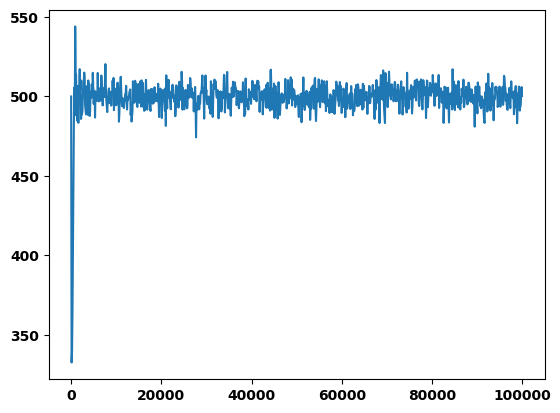

In [18]:
plt.plot(sim.thermo.Step, sim.thermo.Temp)

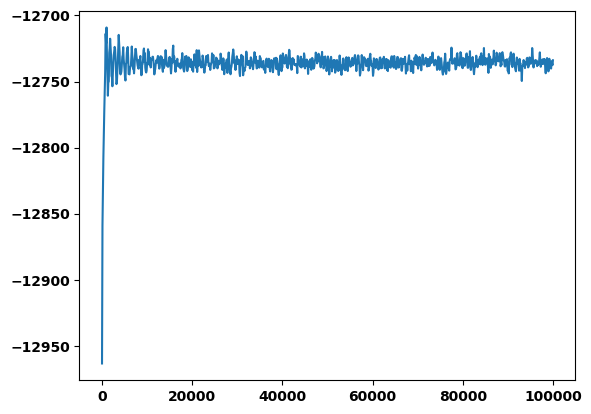

In [19]:
plt.plot(sim.thermo.Step, sim.thermo.PotEng)

In [20]:
relaxed_system = am.load('atom_dump', '10000.dump')

In [21]:
relaxed_system.atoms_df()

atype    pos[0]    pos[1]   pos[2]  atom_id     c_pe      c_ke  \
0         1 -0.000699 -1.545470 -23.9318        1 -2.84279  0.038802   
1         1 -4.334620 -0.461798 -23.8861        2 -2.59776  0.019728   
2         1 -2.288460 -3.244550 -23.7491        3 -2.63690  0.046063   
3         1 -4.574250 -2.643670 -22.5567        4 -3.02440  0.030256   
4         1 -2.059230 -5.878650 -22.6822        5 -2.97188  0.029351   
...     ...       ...       ...      ...      ...      ...       ...   
3992      1 -0.240754  9.365380  22.6313     3993 -2.59955  0.043060   
3993      1  2.056700  1.033090  22.7169     3994 -3.32948  0.029969   
3994      1  4.413660  0.206724  23.8678     3995 -2.58839  0.002676   
3995      1  4.196540  7.481080  22.9323     3996 -2.49727  0.083488   
3996      1  8.840270  1.274570  22.8257     3997 -2.49641  0.013940   

      c_stress[1]  c_stress[2]  c_stress[3]  c_stress[4]  c_stress[5]  \
0       1176020.0     533478.0     -80649.1    -443440.0     227290.0   
1       1446770.0     875011.0     607635.0    -361910.0      -6737.5   
2        468084.0    1539700.0    -312193.0     176111.0     -18666.4   
3        366867.0     479456.0   -1012150.0      16146.9     535703.0   
4       1464810.0    1051160.0     -73135.2     206866.0    -225283.0   
...           ...          ...          ...          ...          ...   
3992    1004500.0     972766.0     -40129.6     294450.0      85655.0   
3993     904461.0     600858.0    -255998.0    -195173.0    -490531.0   
3994    1347960.0     534236.0     331820.0     239564.0    -105698.0   
3995    1143880.0    1193740.0     491470.0    -259266.0    -474668.0   
3996    1691670.0    1641280.0    1079950.0    -461920.0    -688805.0   

      c_stress[6]  
0       -158141.0  
1        651841.0  
2       -404338.0  
3        -31664.4  
4        128341.0  
...           ...  
3992    -153511.0  
3993    -202281.0  
3994     376929.0  
3995    -116366.0  
3996     372038.0  

[3997 rows x 13 columns]

In [22]:
am.plot.py3Dmol.view_3d(relaxed_system, prop_name='c_pe')

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol